## download data
I already downloaded

In [1]:
# linux
!apt-get install wget
# mac
!brew install wget
 
# create a data directory
!mkdir data_dir
 
# download images and annotations to the data directory
!wget http://msvocds.blob.core.windows.net/annotations-1-0-3/captions_train-val2014.zip -P ./data_dir/
!wget http://images.cocodataset.org/zips/train2014.zip -P ./data_dir/
!wget http://images.cocodataset.org/zips/val2014.zip -P ./data_dir/
    
# extract zipped images and annotations and remove the zip files
!unzip ./data_dir/captions_train-val2014.zip -d ./data_dir/
!rm ./data_dir/captions_train-val2014.zip
!unzip ./data_dir/train2014.zip -d ./data_dir/
!rm ./data_dir/train2014.zip 
!unzip ./data_dir/val2014.zip -d ./data_dir/ 
!rm ./data_dir/val2014.zip

E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?
/usr/bin/sh: 1: brew: not found
--2022-08-09 06:03:53--  http://msvocds.blob.core.windows.net/annotations-1-0-3/captions_train-val2014.zip
Resolving msvocds.blob.core.windows.net (msvocds.blob.core.windows.net)... 20.60.195.163
Connecting to msvocds.blob.core.windows.net (msvocds.blob.core.windows.net)|20.60.195.163|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19673183 (19M) [application/octet-stream Charset=UTF-8]
Saving to: ‘./data_dir/captions_train-val2014.zip’

captions_train-val2 100%[===================>]  18.76M  3.00MB/s    in 7.1s    

2022-08-09 06:04:01 (2.65 MB/s) - ‘./data_dir/captions_train-val2014.zip’ saved [19673183/19673183]

--2022-08-09 06:04:01--  http://images.cocodataset.org/zips/train2014.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.2

## import dependencies

In [1]:
import os
import nltk
import pickle
import numpy as np
from PIL import Image
from collections import Counter
from pycocotools.coco import COCO
import matplotlib.pyplot as plt
 
import torch
import torch.nn as nn
import torch.utils.data as data
from torchvision import transforms
import torchvision.models as models
import torchvision.transforms as transforms
from torch.nn.utils.rnn import pack_padded_sequence

In [2]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/mas/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## build vocab

In [2]:
class Vocab(object):
    """Simple vocabulary wrapper."""
    def __init__(self):
        self.w2i = {}
        self.i2w = {}
        self.index = 0
 
    def __call__(self, token):
        if not token in self.w2i:
            return self.w2i['<unk>']
        return self.w2i[token]
 
    def __len__(self):
        return len(self.w2i)
    def add_token(self, token):
        if not token in self.w2i:
            self.w2i[token] = self.index
            self.i2w[self.index] = token
            self.index += 1

def build_vocabulary(json, threshold):
    """Build a simple vocabulary wrapper."""
    coco = COCO(json)
    counter = Counter()
    ids = coco.anns.keys()
    for i, id in enumerate(ids):
        caption = str(coco.anns[id]['caption'])
        tokens = nltk.tokenize.word_tokenize(caption.lower())
        counter.update(tokens)
 
        if (i+1) % 1000 == 0:
            print("[{}/{}] Tokenized the captions.".format(i+1, len(ids)))
 
    # If the word frequency is less than 'threshold', then the word is discarded.
    tokens = [token for token, cnt in counter.items() if cnt >= threshold]
 
    # Create a vocab wrapper and add some special tokens.
    vocab = Vocab()
    vocab.add_token('<pad>')
    vocab.add_token('<start>')
    vocab.add_token('<end>')
    vocab.add_token('<unk>')
 
    # Add the words to the vocabulary.
    for i, token in enumerate(tokens):
        vocab.add_token(token)
    return vocab

In [ ]:
vocab = build_vocabulary(json='data_dir/annotations/captions_train2014.json', threshold=4)
vocab_path = './data_dir/vocabulary.pkl'
with open(vocab_path, 'wb') as f:
    pickle.dump(vocab, f)
print("Total vocabulary size: {}".format(len(vocab)))
print("Saved the vocabulary wrapper to '{}'".format(vocab_path))

## resize images

In [3]:
def reshape_image(image, shape):
    """Resize an image to the given shape."""
    return image.resize(shape, Image.ANTIALIAS)
 
def reshape_images(image_path, output_path, shape):
    """Reshape the images in 'image_path' and save into 'output_path'."""
    if not os.path.exists(output_path):
        os.makedirs(output_path)
 
    images = os.listdir(image_path)
    num_im = len(images)
    for i, im in enumerate(images):
        with open(os.path.join(image_path, im), 'r+b') as f:
            with Image.open(f) as image:
                image = reshape_image(image, shape)
                image.save(os.path.join(output_path, im), image.format)
        if (i+1) % 100 == 0:
            print ("[{}/{}] Resized the images and saved into '{}'."
                   .format(i+1, num_im, output_path))

In [ ]:
image_path = './data_dir/train2014/'
output_path = './data_dir/resized_images/'
image_shape = [256, 256]
reshape_images(image_path, output_path, image_shape)

In [4]:
class CustomCocoDataset(data.Dataset):
    """COCO Custom Dataset compatible with torch.utils.data.DataLoader."""
    def __init__(self, data_path, coco_json_path, vocabulary, transform=None):
        """Set the path for images, captions and vocabulary wrapper.
        
        Args:
            root: image directory.
            json: coco annotation file path.
            vocab: vocabulary wrapper.
            transform: image transformer.
        """
        self.root = data_path
        self.coco_data = COCO(coco_json_path)
        self.indices = list(self.coco_data.anns.keys())
        self.vocabulary = vocabulary
        self.transform = transform
 
    def __getitem__(self, idx):
        """Returns one data pair (image and caption)."""
        coco_data = self.coco_data
        vocabulary = self.vocabulary
        annotation_id = self.indices[idx]
        caption = coco_data.anns[annotation_id]['caption']
        image_id = coco_data.anns[annotation_id]['image_id']
        image_path = coco_data.loadImgs(image_id)[0]['file_name']
 
        image = Image.open(os.path.join(self.root, image_path)).convert('RGB')
        if self.transform is not None:
            image = self.transform(image)
 
        # Convert caption (string) to word ids.
        word_tokens = nltk.tokenize.word_tokenize(str(caption).lower())
        caption = []
        caption.append(vocabulary('<start>'))
        caption.extend([vocabulary(token) for token in word_tokens])
        caption.append(vocabulary('<end>'))
        ground_truth = torch.Tensor(caption)
        return image, ground_truth
 
    def __len__(self):
        return len(self.indices)
 
 
def collate_function(data_batch):
    """Creates mini-batch tensors from the list of tuples (image, caption).
    
    We should build custom collate_fn rather than using default collate_fn, 
    because merging caption (including padding) is not supported in default.
    Args:
        data: list of tuple (image, caption). 
            - image: torch tensor of shape (3, 256, 256).
            - caption: torch tensor of shape (?); variable length.
    Returns:
        images: torch tensor of shape (batch_size, 3, 256, 256).
        targets: torch tensor of shape (batch_size, padded_length).
        lengths: list; valid length for each padded caption.
    """
    # Sort a data list by caption length (descending order).
    data_batch.sort(key=lambda d: len(d[1]), reverse=True)
    imgs, caps = zip(*data_batch)
 
    # Merge images (from list of 3D tensors to 4D tensor).
    # Originally, imgs is a list of <batch_size> number of RGB images with dimensions (3, 256, 256)
    # This line of code turns it into a single tensor of dimensions (<batch_size>, 3, 256, 256)
    imgs = torch.stack(imgs, 0)
 
    # Merge captions (from list of 1D tensors to 2D tensor), similar to merging of images donw above.
    cap_lens = [len(cap) for cap in caps]
    tgts = torch.zeros(len(caps), max(cap_lens)).long()
    for i, cap in enumerate(caps):
        end = cap_lens[i]
        tgts[i, :end] = cap[:end]        
    return imgs, tgts, cap_lens
 
def get_loader(data_path, coco_json_path, vocabulary, transform, batch_size, shuffle, num_workers):
    """Returns torch.utils.data.DataLoader for custom coco dataset."""
    # COCO caption dataset
    coco_dataser = CustomCocoDataset(data_path=data_path,
                       coco_json_path=coco_json_path,
                       vocabulary=vocabulary,
                       transform=transform)
    
    # Data loader for COCO dataset
    # This will return (images, captions, lengths) for each iteration.
    # images: a tensor of shape (batch_size, 3, 224, 224).
    # captions: a tensor of shape (batch_size, padded_length).
    # lengths: a list indicating valid length for each caption. length is (batch_size).
    custom_data_loader = torch.utils.data.DataLoader(dataset=coco_dataser, 
                                              batch_size=batch_size,
                                              shuffle=shuffle,
                                              num_workers=num_workers,
                                              collate_fn=collate_function)
    return custom_data_loader

## instantiate data loader

## model definition

In [5]:
class CNNModel(nn.Module):
    def __init__(self, embedding_size):
        """Load the pretrained ResNet-152 and replace top fc layer."""
        super(CNNModel, self).__init__()
        resnet = models.resnet152(pretrained=True)
        module_list = list(resnet.children())[:-1]      # delete the last fc layer.
        self.resnet_module = nn.Sequential(*module_list) # A sequential container. Modules will be added to it in the order they are passed in the constructor. ref: https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html
        self.linear_layer = nn.Linear(resnet.fc.in_features, embedding_size) #in_feature is the number of inputs for your linear layer.  embedding_size: output size.
        self.batch_norm = nn.BatchNorm1d(embedding_size, momentum=0.01)
        
    def forward(self, input_images):
        """Extract feature vectors from input images."""
        with torch.no_grad():
            resnet_features = self.resnet_module(input_images)
        resnet_features = resnet_features.reshape(resnet_features.size(0), -1)
        final_features = self.batch_norm(self.linear_layer(resnet_features))
        return final_features
 
class LSTMModel(nn.Module):
    def __init__(self, embedding_size, hidden_layer_size, vocabulary_size, num_layers, max_seq_len=20): # embedding_size: input dim. 
        """Set the hyper-parameters and build the layers."""
        super(LSTMModel, self).__init__()
        self.embedding_layer = nn.Embedding(vocabulary_size, embedding_size) # vocabulary_size: size of the dictionary of embeddings, embedding_size: size of each embedding vector. ref: https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html
        self.lstm_layer = nn.LSTM(embedding_size, hidden_layer_size, num_layers, batch_first=True) # ref: https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html
        self.linear_layer = nn.Linear(hidden_layer_size, vocabulary_size)
        self.max_seq_len = max_seq_len

    def forward(self, input_features, capts, lens):
        """Decode image feature vectors and generates captions."""
        embeddings = self.embedding_layer(capts)
        embeddings = torch.cat((input_features.unsqueeze(1), embeddings), 1) # unsqueeze: add dim to specified dim. ref: https://pytorch.org/docs/stable/generated/torch.unsqueeze.html
        lstm_input = pack_padded_sequence(embeddings, lens, batch_first=True) # ref: https://pytorch.org/docs/stable/generated/torch.nn.utils.rnn.pack_padded_sequence.html
        hidden_variables, _ = self.lstm_layer(lstm_input)
        model_outputs = self.linear_layer(hidden_variables[0])
        return model_outputs
    
    def sample(self, input_features, lstm_states=None):
        """Generate captions for given image features using greedy search."""
        sampled_indices = []
        lstm_inputs = input_features.unsqueeze(1)
        for i in range(self.max_seq_len): # (batched) words loop.
            hidden_variables, lstm_states = self.lstm_layer(lstm_inputs, lstm_states)          # hiddens: (batch_size, 1, hidden_size)
            model_outputs = self.linear_layer(hidden_variables.squeeze(1))            # outputs:  (batch_size, vocab_size)
            _, predicted_outputs = model_outputs.max(1)                        # predicted: (batch_size)
            sampled_indices.append(predicted_outputs)
            lstm_inputs = self.embedding_layer(predicted_outputs)                       # inputs: (batch_size, embed_size)
            lstm_inputs = lstm_inputs.unsqueeze(1)                         # inputs: (batch_size, 1, embed_size)
        sampled_indices = torch.stack(sampled_indices, 1)                # sampled_ids: (batch_size, max_seq_length)
        return sampled_indices

In [8]:
# from here. 2022/8/28

## training loop

In [9]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# Create model directory
if not os.path.exists('models_dir/'):
    os.makedirs('models_dir/')

    
# Image preprocessing, normalization for the pretrained resnet
transform = transforms.Compose([ 
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(), 
    transforms.ToTensor(), 
    transforms.Normalize((0.485, 0.456, 0.406), 
                         (0.229, 0.224, 0.225))])


# Load vocabulary wrapper
with open('data_dir/vocabulary.pkl', 'rb') as f:
    vocabulary = pickle.load(f)

    
# Build data loader
custom_data_loader = get_loader('data_dir/resized_images', 'data_dir/annotations/captions_train2014.json', vocabulary, 
                         transform, 128,
                         shuffle=True, num_workers=2) 


# Build the models
encoder_model = CNNModel(256).to(device)
decoder_model = LSTMModel(256, 512, len(vocabulary), 1).to(device)
 
    
# Loss and optimizer
loss_criterion = nn.CrossEntropyLoss()
parameters = list(decoder_model.parameters()) + list(encoder_model.linear_layer.parameters()) + list(encoder_model.batch_norm.parameters())
optimizer = torch.optim.Adam(parameters, lr=0.001)


# Train the models
total_num_steps = len(custom_data_loader)
for epoch in range(5):
    for i, (imgs, caps, lens) in enumerate(custom_data_loader):
 
        # Set mini-batch dataset
        imgs = imgs.to(device)
        caps = caps.to(device)
        tgts = pack_padded_sequence(caps, lens, batch_first=True)[0]
 
        # Forward, backward and optimize
        feats = encoder_model(imgs)
        outputs = decoder_model(feats, caps, lens)
        loss = loss_criterion(outputs, tgts)
        decoder_model.zero_grad()
        encoder_model.zero_grad()
        loss.backward()
        optimizer.step()
 
        # Print log info
        if i % 10 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Perplexity: {:5.4f}'
                  .format(epoch, 5, i, total_num_steps, loss.item(), np.exp(loss.item()))) 
 
        # Save the model checkpoints
        if (i+1) % 1000 == 0:
            torch.save(decoder_model.state_dict(), os.path.join(
                'models_dir/', 'decoder-{}-{}.ckpt'.format(epoch+1, i+1)))
            torch.save(encoder_model.state_dict(), os.path.join(
                'models_dir/', 'encoder-{}-{}.ckpt'.format(epoch+1, i+1)))

loading annotations into memory...
Done (t=0.32s)
creating index...
index created!
Epoch [0/5], Step [0/3236], Loss: 9.2066, Perplexity: 9962.9626
Epoch [0/5], Step [10/3236], Loss: 5.7840, Perplexity: 325.0683
Epoch [0/5], Step [20/3236], Loss: 5.3256, Perplexity: 205.5411
Epoch [0/5], Step [30/3236], Loss: 4.9203, Perplexity: 137.0494
Epoch [0/5], Step [40/3236], Loss: 4.6118, Perplexity: 100.6691
Epoch [0/5], Step [50/3236], Loss: 4.3640, Perplexity: 78.5695
Epoch [0/5], Step [60/3236], Loss: 4.2926, Perplexity: 73.1555
Epoch [0/5], Step [70/3236], Loss: 4.2452, Perplexity: 69.7683
Epoch [0/5], Step [80/3236], Loss: 4.0186, Perplexity: 55.6213
Epoch [0/5], Step [90/3236], Loss: 4.0292, Perplexity: 56.2162
Epoch [0/5], Step [100/3236], Loss: 3.8261, Perplexity: 45.8838
Epoch [0/5], Step [110/3236], Loss: 3.8005, Perplexity: 44.7215
Epoch [0/5], Step [120/3236], Loss: 3.8233, Perplexity: 45.7571
Epoch [0/5], Step [130/3236], Loss: 3.8454, Perplexity: 46.7767
Epoch [0/5], Step [140/323

## predict caption

<start> a dog is sitting on a bench looking at the water . <end>


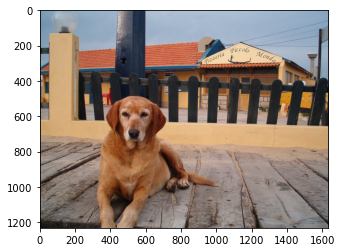

In [10]:
image_file_path = 'sample.jpg'
# image_file_path = 'dookie_highres_multilayer.png'

 

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
 

def load_image(image_file_path, transform=None):
    img = Image.open(image_file_path).convert('RGB')
    img = img.resize([224, 224], Image.LANCZOS)
    
    if transform is not None:
        img = transform(img).unsqueeze(0)
    
    return img
 

# Image preprocessing
transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize((0.485, 0.456, 0.406), 
                         (0.229, 0.224, 0.225))])


# Load vocabulary wrapper
with open('data_dir/vocabulary.pkl', 'rb') as f:
    vocabulary = pickle.load(f)


# Build models
encoder_model = CNNModel(256).eval()  # eval mode (batchnorm uses moving mean/variance)
decoder_model = LSTMModel(256, 512, len(vocabulary), 1)
encoder_model = encoder_model.to(device)
decoder_model = decoder_model.to(device)


# Load the trained model parameters
encoder_model.load_state_dict(torch.load('models_dir/encoder-5-3000.ckpt'))
decoder_model.load_state_dict(torch.load('models_dir/decoder-5-3000.ckpt'))


# Prepare an image
img = load_image(image_file_path, transform)
img_tensor = img.to(device)


# Generate an caption from the image
feat = encoder_model(img_tensor)
sampled_indices = decoder_model.sample(feat)
sampled_indices = sampled_indices[0].cpu().numpy()          # (1, max_seq_length) -> (max_seq_length)


# Convert word_ids to words
predicted_caption = []
for token_index in sampled_indices:
    word = vocabulary.i2w[token_index]
    predicted_caption.append(word)
    if word == '<end>':
        break
predicted_sentence = ' '.join(predicted_caption)


# Print out the image and the generated caption
print (predicted_sentence)
img = Image.open(image_file_path)
plt.imshow(np.asarray(img))